In [1]:
import csv
from datetime import timedelta
import gurobipy as gp 
from gurobipy import GRB
import networkx as nx
import random
import matplotlib.pyplot as plt
import inspect
from collections import defaultdict

from models import simple_mpc, mpc_duration_constr, lazy, column_generation
from helper import Service, hhmm2mins, mins2hhmm, fetch_data, draw_graph_with_edges, node_legal, no_overlap, create_duty_graph, extract_nodes, generate_paths, roster_statistics, solution_verify, solve_RMLP, new_duty_with_bellman_ford, count_overlaps, solve_MIP

In [2]:
import importlib
import models
import helper

importlib.reload(models)
importlib.reload(helper)

from models import simple_mpc, mpc_duration_constr, lazy, column_generation
from helper import Service, hhmm2mins, mins2hhmm, fetch_data, draw_graph_with_edges, node_legal, no_overlap, create_duty_graph, extract_nodes, generate_paths, roster_statistics, solution_verify, solve_RMLP, new_duty_with_bellman_ford, count_overlaps, solve_MIP

In [8]:
services, service_dict = fetch_data('./StepBackServices.csv', partial=True, rakes = 20)       # 46 maximum number of rakes
graph = create_duty_graph(services)
print(graph)

DiGraph with 486 nodes and 8832 edges


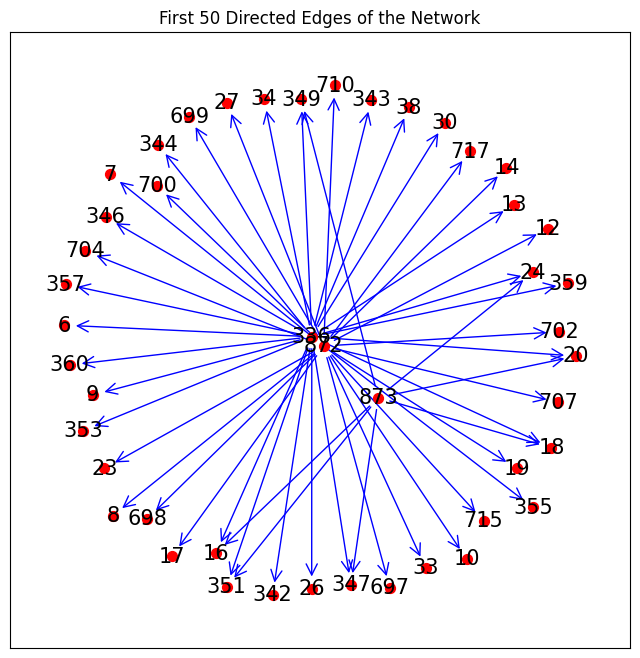

In [9]:
draw_graph_with_edges(graph)

In [10]:
init_duties, duty_count = mpc_duration_constr(graph, service_dict, time_limit = 30, show_logs = False, show_duties = False, show_roster_stats = False)
# init_duties, duty_count = simple_mpc(graph, service_dict, show_logs=False)
print(f"Initial number of duties: {len(init_duties)}")
cutoff_obj = len(init_duties)
print("For MPC method:", "\n")
all_covered = count_overlaps(init_duties, services)
print("\n")
init_duties2 = init_duties.copy()

# for _ in range(2000):
#     selected_duties, duals, selected_duty_vars, obj = solve_RMLP(duties=init_duties2, services=services)
#     path, length, graph_cp = new_duty_with_bellman_ford(graph, duals)
#     print(_, obj, path)
#     if path[1:-1] in init_duties2 or _ == 699:
#         print(f"iteration number {_} breaks......")
#         print("IP starts solving.......")
#         obj, selected_duties, model = solve_MIP(services, duties=init_duties2, cutoff=cutoff_obj, mipgap=0.01, timelimit=60*3)
#         tt = []
#         for duty_num in selected_duties:
#             tt.append(init_duties2[duty_num])
#         count_overlaps(tt, services)
#         break
#     init_duties2.append(path[1:-1])

for _ in range(2000):
    selected_duties, duals, selected_duty_vars, obj = solve_RMLP(duties=init_duties2, services=services)
    path, length, graph_cp = new_duty_with_bellman_ford(graph, duals)
    print(_, obj, length, path)
    if path[1:-1] in init_duties2:
        break
    init_duties2.append(path[1:-1])

print(f"iteration number {_} breaks......")
print("IP starts solving.......")
obj, selected_duties, model = solve_MIP(services, duties=init_duties2, cutoff=cutoff_obj, mipgap=0.01, timelimit=60*60)
tt = []
for duty_num in selected_duties:
    tt.append(init_duties2[duty_num])
count_overlaps(tt, services)

Initial number of duties: 75
For MPC method: 

Number of duties selected: 75
Total number of services: 484
Number of services that overlap in duties: 0
Number of services covered in duties: 484


0 75.0 -8.0 [-2, 877, 340, 359, 374, 398, 412, 161, 796, 812, -1]
1 75.0 -9.0 [-2, 336, 342, 355, 381, 401, 416, 173, 223, 477, -1]
2 75.0 -8.0 [-2, 337, 346, 55, 94, 407, 418, 430, 462, 261, -1]
3 75.0 -8.0 [-2, 873, 347, 362, 379, 405, 421, 177, 804, 225, 263, -1]
4 75.0 -9.0 [-2, 874, 351, 366, 88, 124, 422, 433, 202, 818, 268, -1]
5 75.0 -9.0 [-2, 883, 9, 39, 92, 128, 424, 435, 229, 834, 297, -1]
6 75.0 -9.0 [-2, 879, 349, 46, 746, 763, 152, 438, 457, 493, 514, -1]
7 75.0 -8.0 [-2, 884, 13, 49, 385, 115, 156, 442, 235, 299, -1]
8 75.0 -9.0 [-2, 338, 16, 53, 95, 148, 440, 454, 251, 302, -1]
9 75.0 -9.0 [-2, 2, 26, 65, 392, 409, 426, 446, 247, 844, 313, 525, -1]
10 75.0 -9.0 [-2, 337, 18, 728, 743, 134, 428, 195, 240, 903, -1]
11 75.0 -8.0 [-2, 337, 20, 58, 398, 419, 181, 223, 491, 507, -1]


KeyboardInterrupt: 

In [12]:
obj, selected_duties, model = solve_MIP(services, duties=init_duties2, cutoff=cutoff_obj, mipgap=0.001, timelimit=60*60)
tt = []
for duty_num in selected_duties:
    tt.append(init_duties2[duty_num])
count_overlaps(tt, services)

Number of duties selected: 75
Total number of services: 484
Number of services that overlap in duties: 0
Number of services covered in duties: 484


True

In [7]:
for duty in init_duties:
    if duty not in tt:
        print(duty)

[527, 533, 541]
[926, 531, 550, 559, 568, 577, 586, 595, 604, 613, 622, 631, 640, 649, 658, 667, 675, 681]
[538, 547, 556, 565, 574, 583, 592, 601, 610, 619, 628, 637, 646, 655, 664, 673, 679, 684]


In [15]:
xd = init_duties.copy()

In [20]:
for duty in xd:
    if duty not in init_duties:
        print(duty)

[336, 28, 729, 81, 402]
[872, 697, 14, 367, 80]
[873, 347, 38, 736, 94, 129]
[875, 703, 27, 111, 770, 784]
[876, 700, 21, 59, 748, 116]
[877, 344, 32, 757, 130, 161]
[878, 699, 19, 370]
[879, 362, 377, 96, 132, 173]
[527, 538, 547, 556]
[880, 704, 29, 397]
[926, 533, 540, 549, 558, 567, 575, 583, 591, 599, 607, 615, 623, 632, 641, 650, 659, 669, 678, 691]
[927, 698, 17, 52, 743, 894, 899]
[0, 705, 31, 70, 751]
[881, 10, 42, 737, 97, 408]
[928, 707, 35, 378, 391, 405]
[693, 701, 23, 372, 86]
[337, 18, 102, 410]
[694, 8, 57, 746, 112, 416]
[883, 364, 74, 753]
[1, 710, 41]
[2, 22, 65, 103, 771, 783]
[884, 360, 66, 750, 118, 418]
[929, 714, 728, 79, 399]
[695, 706, 49, 88]
[3, 26, 730, 83]
[338, 16, 722, 67, 394, 409]
[4, 711, 43, 382, 395]
[696, 12, 50, 93, 407, 149]
[5, 355, 371, 393, 412, 159]
[339, 20, 106, 413, 424, 436, 217]
[340, 30, 731, 100]
[6, 33, 72, 110, 415, 169]
[7, 357, 63, 755, 898]
[885, 708, 37, 379, 392, 135]
[341, 353, 368]
[342, 359, 64, 104]
[343, 46, 85]
[532, 541, 

In [ ]:
# To check number of services that overlap in all selected duties
# Run after column generation

for i in range(1, 21, 2):
    tt = 0.01 * i
    init_duties, duty_count = mpc_duration_constr(graph, service_dict, time_limit = 20, show_logs = False, show_duties = False, show_roster_stats = False)
    print(f"Initial number of duties: {len(init_duties)}", "\n", "For MPC method:", "\n")
    all_covered = count_overlaps(init_duties, services)
    print("\n")
    init_duties2 = init_duties.copy()
    objectives, selected_duties, indexes = column_generation(method=1, graph = graph, services = services, init_duties= init_duties2, num_iter = 400, threshold=tt) 
    print(f"Threshold: {tt}")
    all_covered = count_overlaps(selected_duties, services)
    print("\n")
    if not all_covered:
        print("<---------------------Not all services covered in the previous iteration--------------------->")
        break

<h3>For number of rakes = 3</h3>
Threshold: 0.17<br>
Number of duties selected: 18<br>
Total number of services: 64<br>
Number of services that overlap in duties: 55<br>
Number of services covered in duties: 64<br>

<h3>For number of rakes = 4 </h3>
Threshold: 0.15<br>
Number of duties selected: 29<br>
Total number of services: 86<br>
Number of services that overlap in duties: 64<br>
Number of services covered in duties: 86<br>

<h3>For number of rakes = 5 </h3>
Threshold: 0.18<br>
Number of duties selected: 33<br>
Total number of services: 106<br>
Number of services that overlap in duties: 84<br>
Number of services covered in duties: 106<br>

In [13]:
init_duties, duty_count = mpc_duration_constr(graph, service_dict, time_limit = 10, show_logs = False, show_duties = False, show_roster_stats = False)
print(init_duties)

[[336, 343, 30, 741, 128], [872, 698, 69, 398, 426, 459, 475, 490, 507], [873, 349, 50, 757, 158, 438], [527], [880, 56, 95, 772, 206, 241], [693, 7, 34, 73, 111], [1, 718, 89, 125, 790, 805, 834], [929, 14, 63, 765, 194, 229, 842], [5, 359, 382, 107, 777, 210, 247], [702, 726, 763, 168, 462, 263, 299], [18, 734, 140, 433, 453, 470, 496, 511], [351, 366, 388, 405, 161, 796, 225, 499], [23, 390, 418, 192, 831, 847, 867], [724, 102, 424, 202, 278, 905], [135, 798, 810, 266, 903], [144, 177, 825, 284, 316], [173, 236, 273, 307], [914], [917], [684]]


In [18]:
# block to write selected duties to csv file

output_filename = "duties_after_gen/duties_after_gen_701_all.csv"

with open(output_filename, mode="w", newline="") as file:
    # Define column headers
    fieldnames = [
        "Service Number", "Train Number", "Start Station", "Start Time (mins)", 
        "End Station", "End Time (mins)", "Direction", "Service Duration", 
        "Jurisdiction", "Stepback Train Number", "Break Duration", "Trip Duration",
        "Duty Duration"  # New column for total duty duration
    ]
    
    writer = csv.writer(file)
    writer.writerow(fieldnames)  # Write header

    for duty in selected_duties:
        # Calculate total duty duration (from first service start time to last service end time)
        valid_services = [service_dict[s] for s in duty if s in service_dict]
        if valid_services:
            duty_start_time = min(s.start_time for s in valid_services)
            duty_end_time = max(s.end_time for s in valid_services)
            total_duty_duration = duty_end_time - duty_start_time

            for service in valid_services:
                writer.writerow([
                    service.serv_num, service.train_num, service.start_stn, service.start_time,
                    service.end_stn, service.end_time, service.direction, service.serv_dur,
                    service.jurisdiction, service.stepback_train_num, service.break_dur, service.trip_dur,
                    total_duty_duration  # Add total duty duration for each service
                ])
        writer.writerow([])  # Add an empty row to separate duties

print(f"CSV file '{output_filename}' generated successfully.")

CSV file 'duties_after_gen/duties_after_gen_701_all.csv' generated successfully.


In [19]:
# block to calculate duty times

print(indexes)
duty_times = []
for duty in selected_duties:
    duty_time = 0
    for serv in duty:
        for service in services:
            if service.serv_num == serv:
                duty_time += service.serv_dur
                break
    duty_times.append(mins2hhmm(duty_time))
# for i in range(len(selected_duties)):
#     print(selected_duties[i], duty_times[i])


[7, 42, 50, 72, 81, 84]


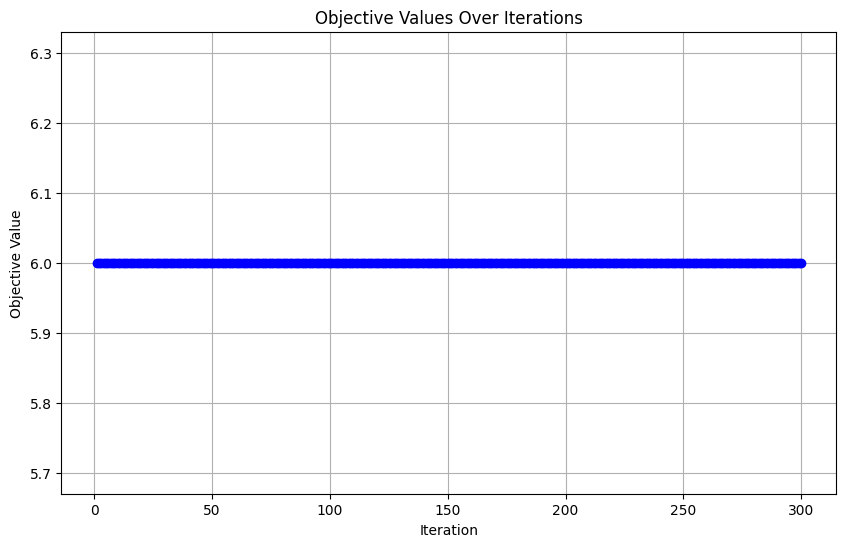

In [20]:
# block to plot objective values over iterations

iterations = range(1, len(objectives) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, objectives, marker='o', linestyle='--', color='b')
plt.title('Objective Values Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.grid(True)
plt.show()